# TD 4 - Explainable AI - Movies dataset

# Imports

In [78]:
# Data visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Machine Learning
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

#Linear Regression
from sklearn.linear_model import LinearRegression

#XGboost
from xgboost import XGBClassifier

#Shapley values
import shap
import scipy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Warnings
import warnings
warnings.simplefilter("ignore")

# Data Processing

In [2]:
df = pd.read_csv("movies.csv")

In [3]:
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


## Missing values

In [5]:
valeurs_nulles = df.isna().sum()

# Calculez le pourcentage de valeurs nulles dans chaque colonne
missing_percentage = (valeurs_nulles / len(df)) * 100

# Créez un DataFrame récapitulatif des valeurs nulles
missing_summary = pd.DataFrame({'Number of Missing Values': valeurs_nulles, 'Percentage': missing_percentage})
missing_summary = missing_summary.sort_values(by='Percentage', ascending=False)

print(missing_summary)

          Number of Missing Values  Percentage
budget                        2171   28.312467
gross                          189    2.464789
rating                          77    1.004173
company                         17    0.221701
runtime                          4    0.052165
score                            3    0.039124
votes                            3    0.039124
writer                           3    0.039124
country                          3    0.039124
released                         2    0.026082
star                             1    0.013041
name                             0    0.000000
genre                            0    0.000000
year                             0    0.000000
director                         0    0.000000


We see that 28% of our dataset is missing, if we do a dropna, we will lose 28% of our dataset. Let's impute these missing 28%. 

First, let's see the budget repartition:

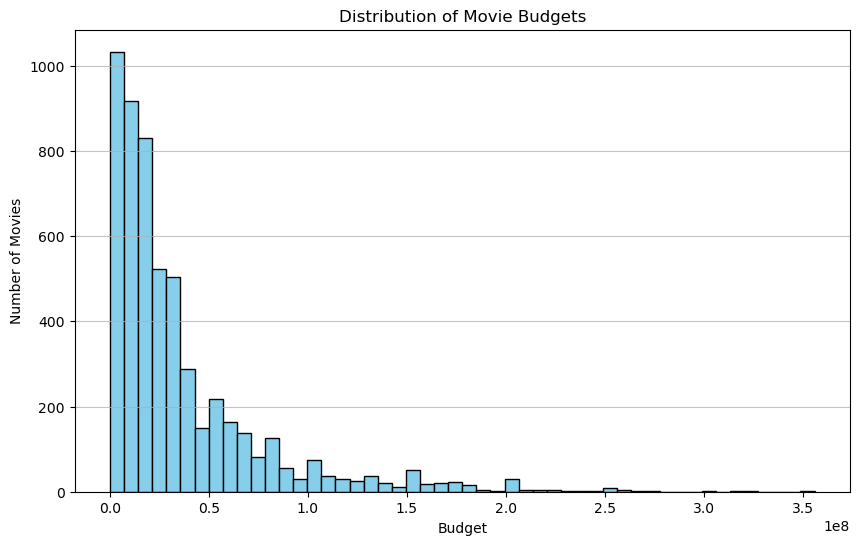

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df['budget'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Budgets')
plt.xlabel('Budget')
plt.ylabel('Number of Movies')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [7]:
# Step 1: Safely divide the 'gross' revenue into quantiles, handling NaN values
df = df[df['gross'].notna()]
df['gross_quantile'] = pd.qcut(df['gross'], q=20, labels=False)

# Step 2: Calculate the median budget for each gross revenue quantile
median_budget_by_gross_quantile = df.groupby('gross_quantile')['budget'].median()

# Step 3: Define a function to impute missing budget values based on the quantile
def impute_budget(row, median_budgets):
    # Check if the budget is missing
    if pd.isnull(row['budget']):
        # Use the median budget of the corresponding gross quantile
        return median_budgets.get(row['gross_quantile'], None)
    else:
        # If the budget is not missing, return it as is
        return row['budget']

# Apply the imputation function across the DataFrame
df['budget'] = df.apply(impute_budget, axis=1, args=(median_budget_by_gross_quantile,))

# Verify the imputation
missing_budget_after_imputation = df['budget'].isna().sum()
missing_budget_after_imputation, median_budget_by_gross_quantile

(0,
 gross_quantile
 0       4000000.0
 1       5000000.0
 2       6700000.0
 3       8000000.0
 4      10000000.0
 5      10000000.0
 6      12000000.0
 7      15000000.0
 8      15000000.0
 9      14400000.0
 10     15000000.0
 11     20000000.0
 12     20000000.0
 13     24000000.0
 14     28000000.0
 15     30000000.0
 16     40000000.0
 17     50000000.0
 18     70000000.0
 19    130000000.0
 Name: budget, dtype: float64)

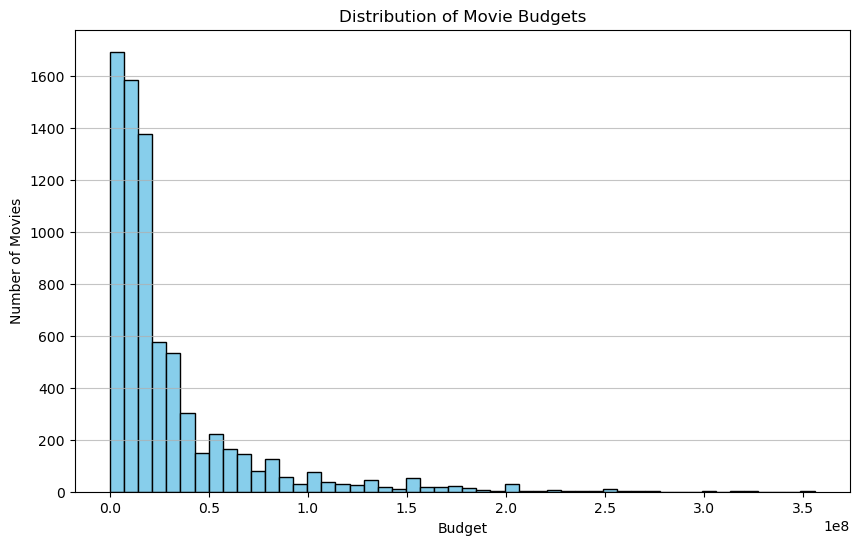

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(df['budget'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Budgets')
plt.xlabel('Budget')
plt.ylabel('Number of Movies')
plt.grid(axis='y', alpha=0.75)
plt.show()

We can see that there are a lot more low-budget films, which is consistent with having missing data. The lower the film's budget, the less documentation there is on it.

In [9]:
df = df.dropna()
len(df.dropna())

7412

We have kept a large amount of data.

## Cleaning and Changing Country to GDP

In [10]:
df['country'].unique()

array(['United Kingdom', 'United States', 'South Africa', 'West Germany',
       'Canada', 'Italy', 'France', 'Australia', 'South Korea', 'Sweden',
       'Spain', 'Hong Kong', 'Mexico', 'Switzerland', 'Netherlands',
       'New Zealand', 'Philippines', 'Japan', 'Brazil', 'Yugoslavia',
       'Argentina', 'Taiwan', 'Israel', 'Denmark', 'Ireland', 'Germany',
       'China', 'Belgium', 'Austria', 'Portugal', 'Vietnam',
       'Republic of Macedonia', 'Russia',
       'Federal Republic of Yugoslavia', 'Iran', 'Czech Republic',
       'Norway', 'Jamaica', 'Aruba', 'India', 'Thailand', 'Hungary',
       'Colombia', 'Romania', 'Greece', 'United Arab Emirates',
       'Indonesia', 'Turkey', 'Serbia', 'Poland', 'Kenya', 'Finland',
       'Iceland', 'Chile', 'Panama', 'Malta', 'Lebanon'], dtype=object)

Let's import a dataset with just the countries of interest and their gdp. This will allow us to replace the film's country with its gdp.

In [11]:
df_gdp = pd.read_csv("gdp_movies.csv")
df_gdp.head()

,country,gdp
0,Argentina,545.476103
1,Australia,1204.616440
2,Austria,390.799991
3,Belgium,467.955710
4,Brazil,1796.186586


In [12]:
# Merge the GDP data into your movies DataFrame
df = df.merge(df_gdp, on='country', how='left')

# Drop the original 'country' column as it's replaced by 'gdp'
df.drop('country', axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7412 entries, 0 to 7411
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            7412 non-null   object 
 1   rating          7412 non-null   object 
 2   genre           7412 non-null   object 
 3   year            7412 non-null   int64  
 4   released        7412 non-null   object 
 5   score           7412 non-null   float64
 6   votes           7412 non-null   float64
 7   director        7412 non-null   object 
 8   writer          7412 non-null   object 
 9   star            7412 non-null   object 
 10  budget          7412 non-null   float64
 11  gross           7412 non-null   float64
 12  company         7412 non-null   object 
 13  runtime         7412 non-null   float64
 14  gross_quantile  7412 non-null   int64  
 15  gdp             7303 non-null   float64
dtypes: float64(6), int64(2), object(8)
memory usage: 926.6+ KB


Let's keep our columns of interest:

In [14]:
columns_to_keep = ['rating', 'genre', 'year', 'score', 'votes', 'budget', 'gross', 'runtime', 'gdp']
df = df[columns_to_keep]

# Data Visualization

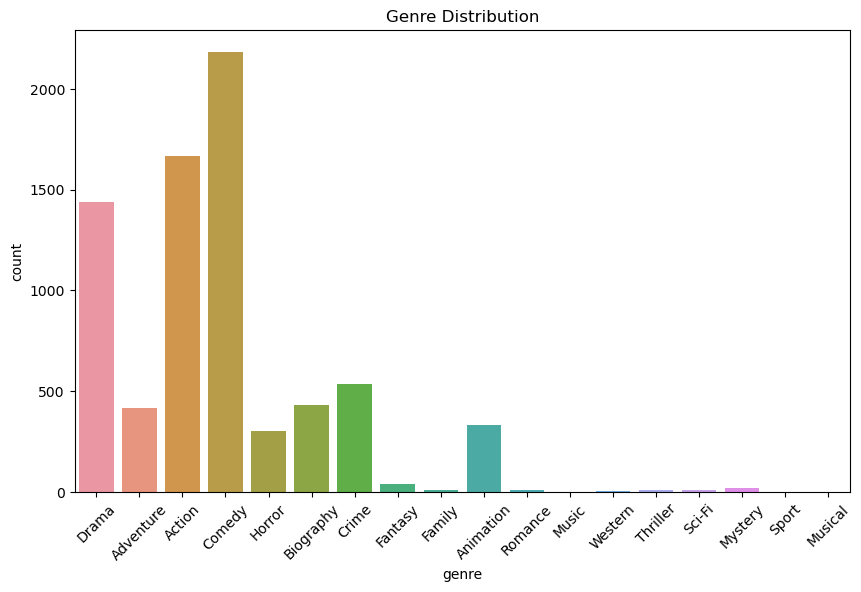

In [15]:
# Genre Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='genre')
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.show()

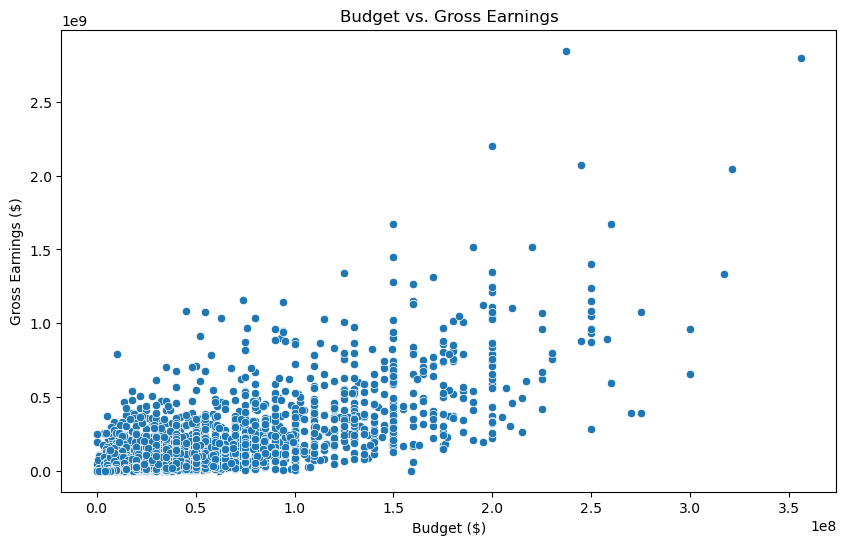

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='budget', y='gross')
plt.title('Budget vs. Gross Earnings')
plt.xlabel('Budget ($)')
plt.ylabel('Gross Earnings ($)')
plt.show()

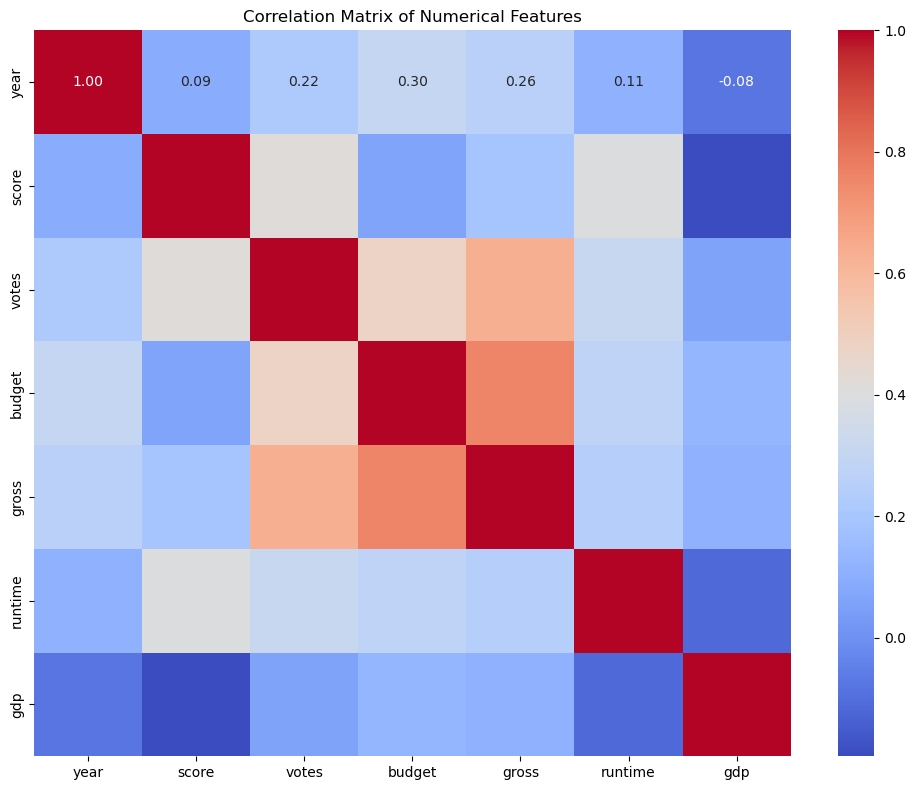

In [17]:
# Creating a correlation matrix for numerical features in the dataset
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

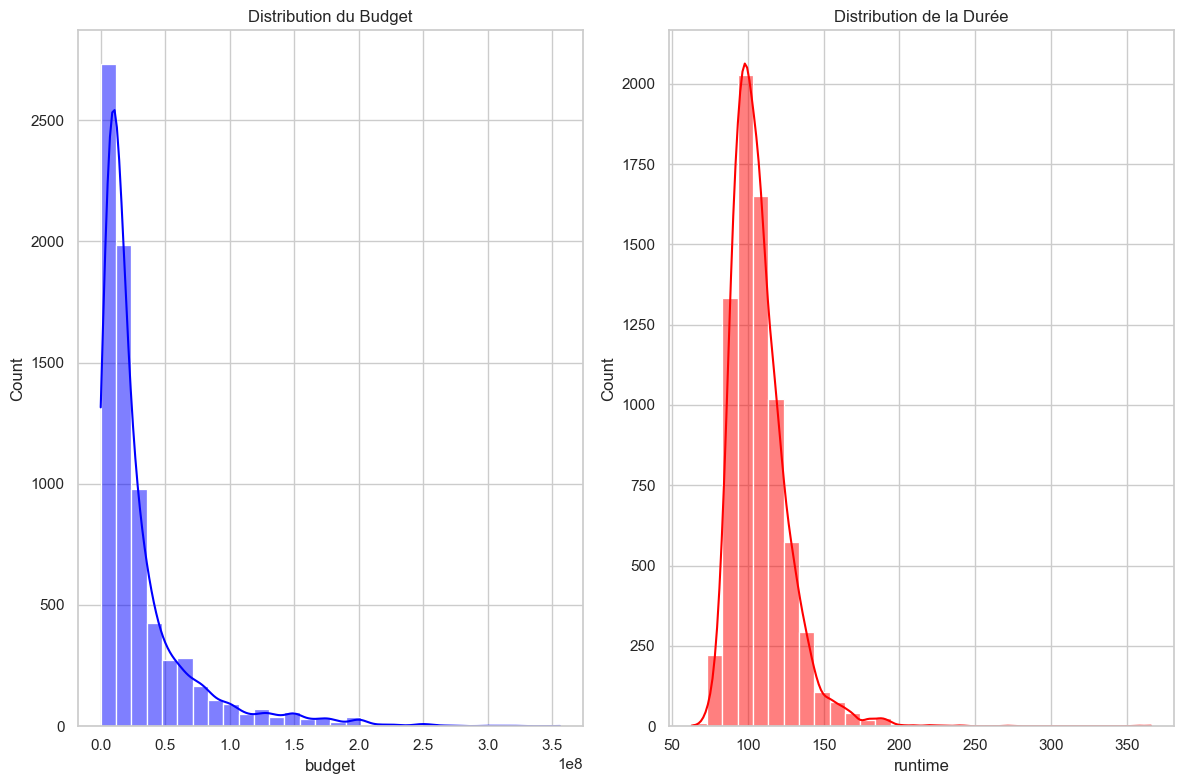

In [18]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sns.histplot(data=df, x='budget', bins=30, ax=axes[0], kde=True, color='blue')
axes[0].set_title('Distribution du Budget')


sns.histplot(data=df, x='runtime', bins=30, ax=axes[1], kde=True, color='red')
axes[1].set_title('Distribution de la Durée')


plt.tight_layout()
plt.show()

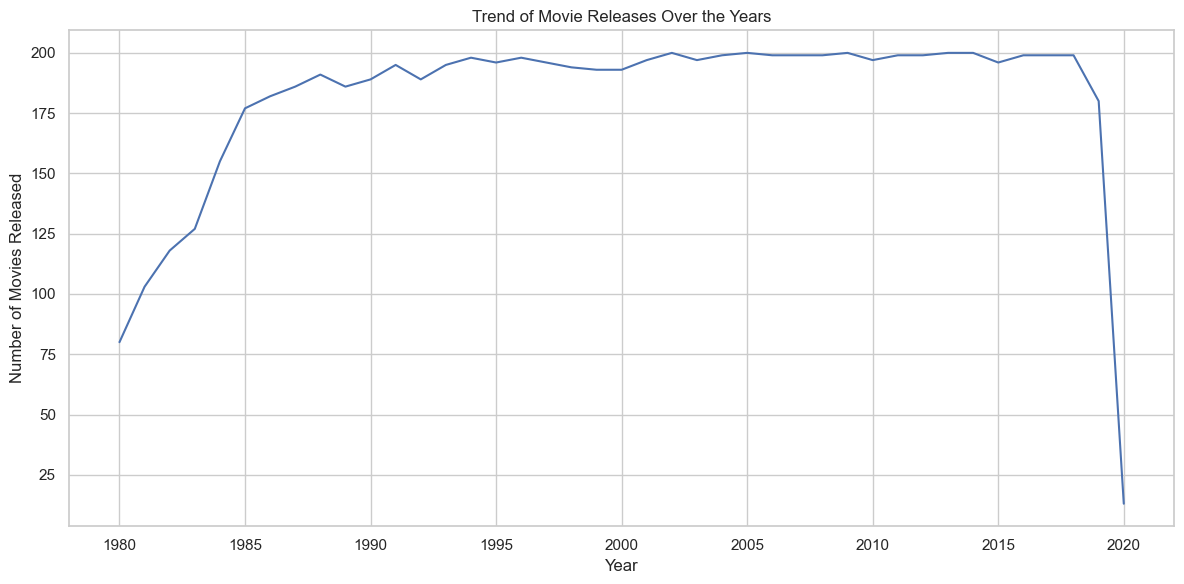

In [19]:
df['year'] = pd.to_datetime(df['year'], format='%Y') # Convert year to datetime

plt.figure(figsize=(12, 6))
df['year'].dt.year.value_counts().sort_index().plot(kind='line')
plt.title('Trend of Movie Releases Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')

plt.tight_layout()
plt.show()

df['year'] = pd.DatetimeIndex(df['year']).year

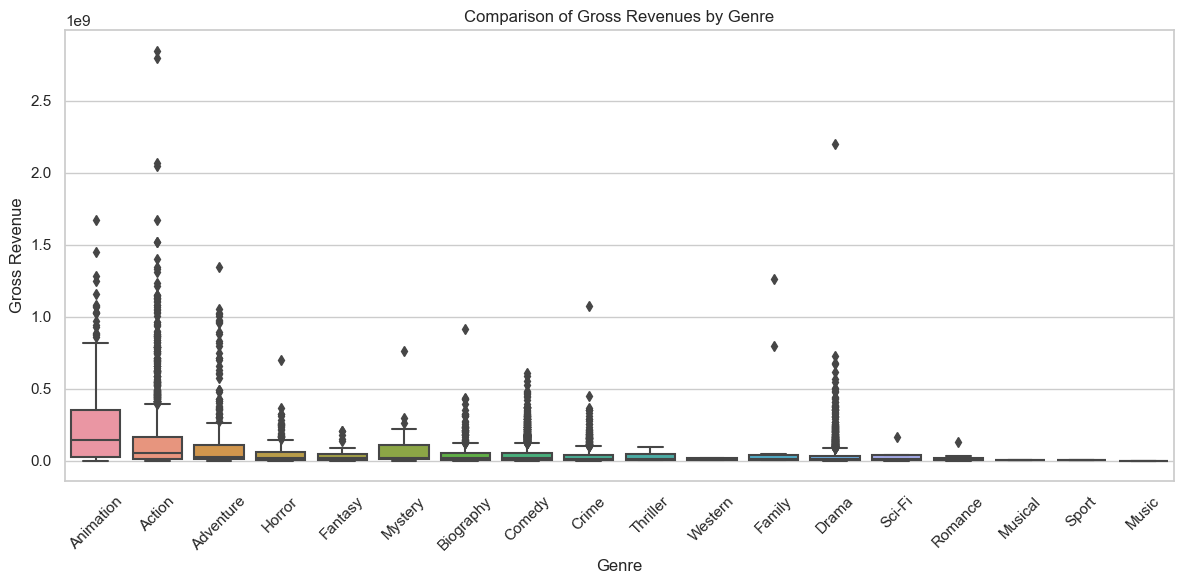

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='genre', y='gross', order=df.groupby('genre')['gross'].median().sort_values(ascending=False).index)
plt.xticks(rotation=45)
plt.title('Comparison of Gross Revenues by Genre')
plt.xlabel('Genre')
plt.ylabel('Gross Revenue')

plt.tight_layout()
plt.show()

In [21]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7303 entries, 0 to 7411
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   rating   7303 non-null   object 
 1   genre    7303 non-null   object 
 2   year     7303 non-null   int32  
 3   score    7303 non-null   float64
 4   votes    7303 non-null   float64
 5   budget   7303 non-null   float64
 6   gross    7303 non-null   float64
 7   runtime  7303 non-null   float64
 8   gdp      7303 non-null   float64
dtypes: float64(6), int32(1), object(2)
memory usage: 542.0+ KB


# Machine Learning

In [22]:
# Redefine the function to categorize films based on the new numerical scheme
def categorize_film_numerically(score):
    if score > 8:
        return 1  # Hit
    elif score < 5:
        return 0  # Flop
    else:
        return 0.5  # Neither

# Apply the new categorization function
df['category'] = df['score'].apply(categorize_film_numerically)

# Drop the 'score' column as before
df.drop('score', axis=1, inplace=True)

# Display the modified dataframe to confirm the changes
df.head()

,rating,genre,year,votes,budget,gross,runtime,gdp,category
0,R,Drama,1980,927000.0,19000000.0,46998772.0,146.0,2647.898655,1.0
1,R,Adventure,1980,65000.0,4500000.0,58853106.0,104.0,18624.475000,0.5
2,PG,Action,1980,1200000.0,18000000.0,538375067.0,124.0,18624.475000,1.0
3,PG,Comedy,1980,221000.0,3500000.0,83453539.0,88.0,18624.475000,0.5
4,R,Comedy,1980,108000.0,6000000.0,39846344.0,98.0,18624.475000,0.5


## Linear Regression

In [23]:
# Since 'rating' and 'genre' are categorical, we'll one-hot encode them.
# For numerical features like 'year', 'votes', 'budget', 'gross', 'runtime', and 'gdp', we'll apply standard scaling.
# We don't apply transformations like log directly here, but let's keep an eye on the model performance and consider it later if necessary.

categorical_features = ['rating', 'genre']
numerical_features = ['year', 'votes', 'budget', 'gross', 'runtime', 'gdp']

In [24]:
categorical_transformer = OneHotEncoder(drop='first')

In [25]:
# StandardScaler for numerical features
numerical_transformer = StandardScaler()

# ColumnTransformer to apply transformations to the appropriate columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [26]:
# Define the regression model in a pipeline, with preprocessing
regression_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regressor', LinearRegression())])

In [27]:
# Define X and y
X = df.drop('category', axis=1)
y = df['category']

In [28]:
# Fit the linear regression model
regression_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'votes', 'budget',
                                                   'gross', 'runtime', 'gdp']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['rating', 'genre'])])),
                ('regressor', LinearRegression())])

In [29]:
coefficients = regression_pipeline.named_steps['regressor'].coef_
feature_names = numerical_features + list(regression_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

In [65]:
# Construct a DataFrame to display coefficients and feature names together for easier interpretation
coef_df = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient'])

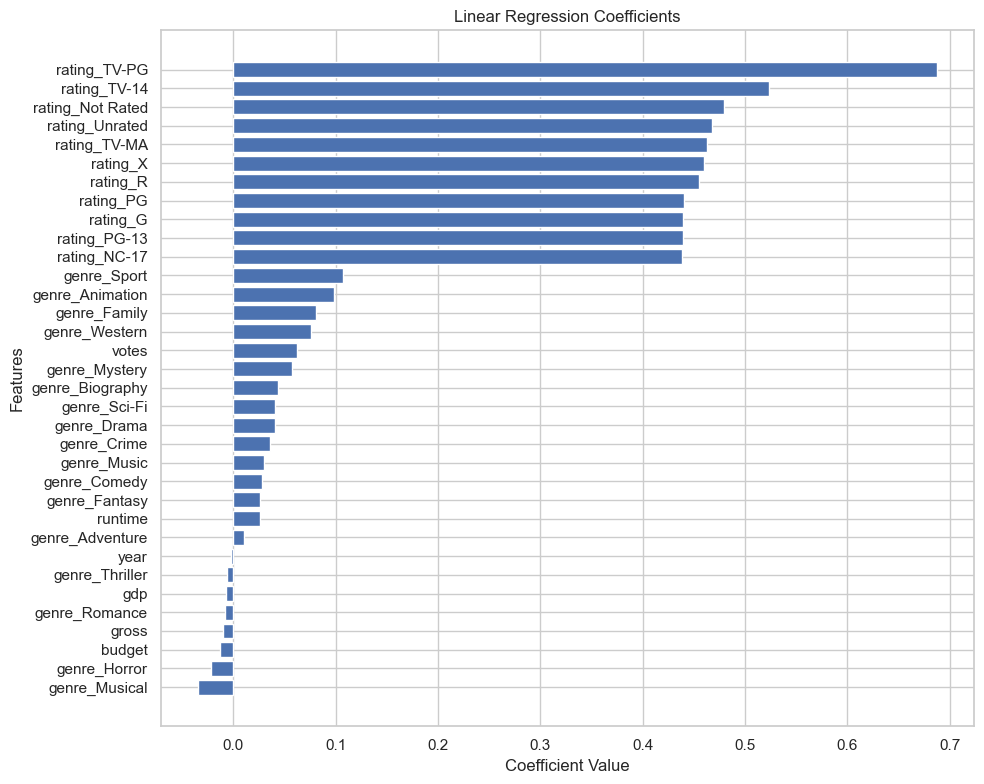

In [31]:
# Assuming `coefficients_df` is your DataFrame with coefficients
coef_df.sort_values(by='Coefficient', inplace=True)

plt.figure(figsize=(10, 8))
plt.barh(coef_df.index, coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Linear Regression Coefficients')
plt.tight_layout()
plt.show()

The linear regression coefficients suggest:

Recent movies are slightly less likely to be hits, contrary to what one might expect.
More votes on a movie correlate with a higher chance of being a hit, which makes sense as it indicates popularity.
Surprisingly, higher budget and gross earnings do not guarantee a movie will be a hit, showing that spending more money or earning more doesn't always lead to success.
Longer movies tend to be more successful, suggesting that audiences might appreciate more in-depth storytelling.
Specific ratings (like TV-PG) and genres (such as Animation and Sport) are more likely to be hits, indicating certain content types fare better.
Conversely, Horror and Musical genres have a slightly lower chance of being hits, which might seem unexpected, especially for horror fans.

## More Complex Model

In [32]:
# Preparing the data: Encoding categorical variables and splitting the dataset
X = df.drop('category', axis=1)
y = df['category'].apply(lambda x: int(x * 2))  # Adjusting targets for classification: 0, 1, 2

In [33]:
# Encoding categorical features
categorical_features = ['rating', 'genre']
numerical_features = X.columns.drop(categorical_features).tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [34]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Setting up the XGBoost classifier within a pipeline
xgboost_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', XGBClassifier(eval_metric='mlogloss', use_label_encoder=False))])

In [36]:
# Define the parameters grid for GridSearchCV
param_grid = {
    'classifier__max_depth': [3, 4, 5],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}

In [37]:
# Using GridSearchCV to find the best parameters
grid_search = GridSearchCV(xgboost_pipeline, param_grid, cv=5, scoring='accuracy')

# Fitting the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_

In [38]:
# Predictions on the test set
y_pred = grid_search.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)

best_params, accuracy

({'classifier__learning_rate': 0.2,
  'classifier__max_depth': 3,
  'classifier__n_estimators': 50},
 0.9137577002053389)

The model, with about 91.4% accuracy, is quite good. It's doing well at predicting if a movie will be a hit or a flop based on its features. This is a strong result for such a complex task.

Use Cases:

Investment Guidance: Help movie producers decide which projects might be worth investing in.
Marketing Insights: Guide marketing teams on how to promote movies effectively.
Content Recommendations: Assist streaming services in recommending movies that are likely to be hits with their audience.

##  Shapley Values

In [39]:
X = df.drop(['category'], axis=1)
y = df['category'].apply(lambda x: int(x * 2))

In [40]:
label_encoders = {}
for column in ['rating', 'genre']:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Initialize and train XGBoost model with previously identified best parameters
best_params = {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
model = XGBClassifier(**best_params, eval_metric='mlogloss', use_label_encoder=False)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [43]:
# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

In [44]:
# Save the explainer for later use
shap_values.data = X_train  # Save training data for plots

# The code for plotting will be provided next. We're preparing SHAP values here.
shap_values

.values =
array([[[-1.58956330e-02, -1.22881301e-01, -5.21989502e-02],
        [-2.31609076e-01,  1.70732304e-01,  6.79766387e-02],
        [-4.00024317e-02,  2.89022587e-02,  5.75963818e-02],
        ...,
        [ 3.73253599e-02,  6.72985762e-02,  3.82917494e-01],
        [ 2.92631805e-01, -1.96799219e-01, -9.06885326e-01],
        [-1.14527695e-01, -1.77478805e-01,  4.62450147e-01]],

       [[ 3.13653238e-02, -4.10252661e-02, -1.16107194e-03],
        [ 1.22616209e-01, -4.70947810e-02, -4.22460735e-02],
        [-3.22536714e-02, -1.03323609e-02,  8.60529020e-02],
        ...,
        [-8.52195919e-03, -1.44855650e-02, -1.50673196e-01],
        [ 4.05946404e-01, -3.23673189e-01, -5.38284123e-01],
        [ 5.98000996e-02, -1.04207238e-02, -3.65838587e-01]],

       [[ 6.59930333e-02, -1.67200491e-01,  8.66528507e-03],
        [-3.08336675e-01,  4.48317528e-02,  5.97090870e-02],
        [-2.00673053e-03, -4.04647142e-02, -3.93391810e-02],
        ...,
        [-1.48230849e-03, -3.141

In [45]:
# For a multi-output model, focusing on the first class
shap.force_plot(explainer.expected_value[0], shap_values.values[0][..., 0], X_train.iloc[0])

Base Value: The base value (also called the expected value) is the average prediction for the dataset, over which individual contributions are added or subtracted. It's the starting point for the SHAP value calculation.

Output Value (f(x)): This is the actual prediction for this particular instance. It is the sum of the base value and all the individual SHAP values.

Red Features (Pushing Right): Features shown in red contribute to increasing the prediction value for this particular instance. In this case, runtime = 90 is increasing the prediction score significantly.

Blue Features (Pushing Left): Features in blue contribute to decreasing the prediction value. For example, the genre = 6 is pushing the prediction to be lower.

Size of the Arrow: The size of the arrow or bar represents the magnitude of the feature's impact. Longer bars mean a stronger influence on the prediction outcome.

From this force plot, you can see which features are pushing the prediction to be higher (more towards being a 'hit') and which ones are pushing it to be lower (more towards being a 'flop'). The combination of these effects, both positive and negative, results in the final prediction made by the model for this specific instance.

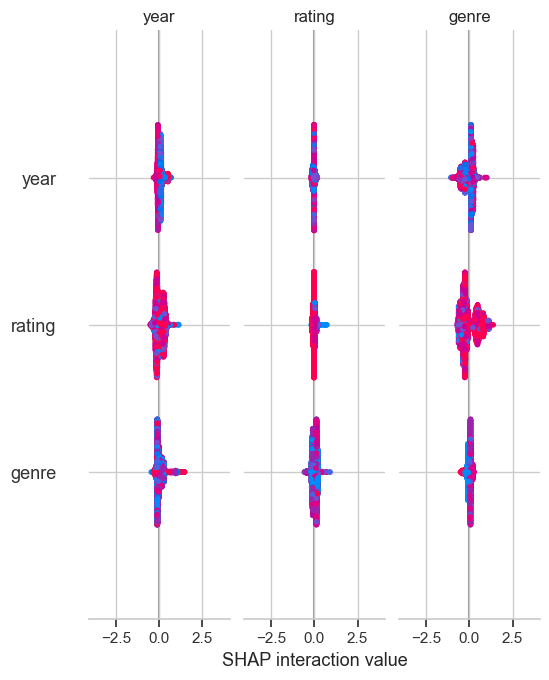

In [73]:
# Generate a summary plot to show global feature importance
shap.summary_plot(shap_values.values, X_train, plot_type="bar")

Each point on the plot represents a SHAP value for a feature and an instance in the dataset. The position on the x-axis indicates the SHAP value, which is a measure of impact on the model output. A SHAP value of zero means the feature had no impact on the model's prediction for that particular instance.
The color represents the value of the feature: red indicates higher values, and blue indicates lower values.
Features are arranged along the y-axis in order of importance, with the most impactful features at the top.
The spread of points in the x-axis direction shows the distribution of the impact that feature has on predictions across all the data points. Wider distributions mean a feature has varying effects depending on the specific instance.ce.

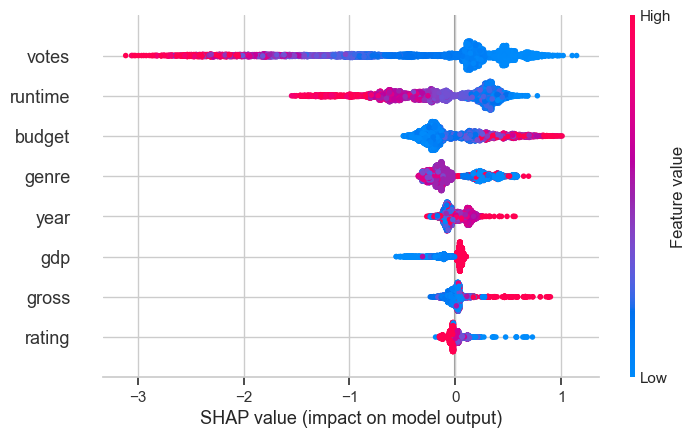

In [47]:
# Select SHAP values
shap_values_class = shap_values[...,0]  # 0 for the flop class, 1 for the "neither" class, 2 for the hit class.

# Generate a beeswarm plot for the flop class
shap.plots.beeswarm(shap_values_class)

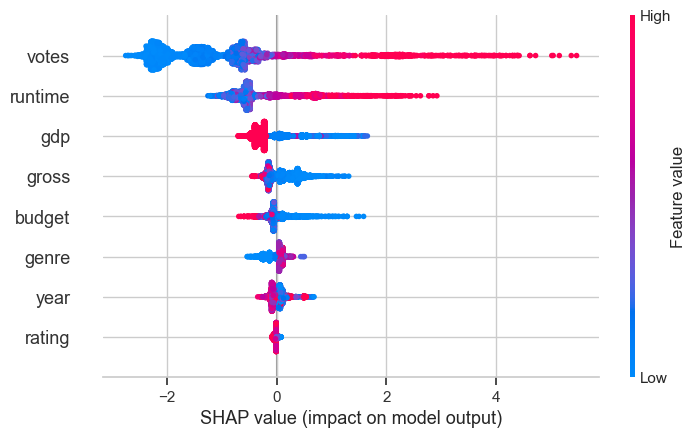

In [48]:
# Select SHAP values
shap_values_class = shap_values[...,2]  # 0 for the flop class, 1 for the "neither" class, 2 for the hit class.

# Generate a beeswarm plot for the hit class
shap.plots.beeswarm(shap_values_class)

Common Interpretations:

Votes: In both plots, a higher number of votes (red points) has a significant positive impact, pushing predictions towards being a hit, while a lower number of votes (blue points) tends towards a flop

.
Runtime: Longer runtime appears to push towards a hit, which might indicate that movies with more substantial content are preferred by the audience or rated more highl

y.
Budget: The budget has a mixed effect, with a higher budget sometimes contributing to a movie being a hit or a flop. This indicates that a larger budget doesn't necessarily predict succe

ss.
Genre & Rating: The specific genre and rating encoded numbers impact predictions in various ways, which would need decoding to interpret effective

ngs.
The most important variables seem consistent across both classes, with 'votes' and 'runtime' being significant predictors.tors.

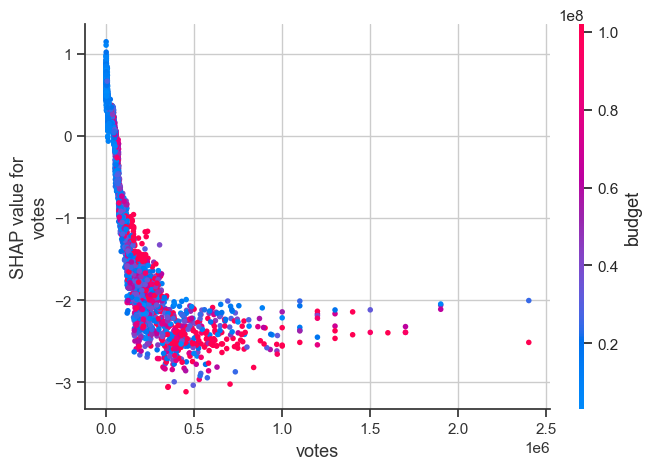

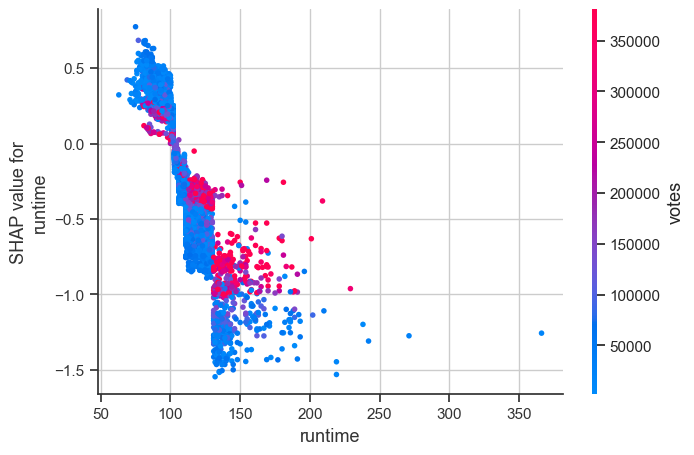

In [76]:
class_index = 0 # 0 for flop

# Now select the SHAP values for that class
shap_values_for_class = shap_values[..., class_index]

# Generate dependence plots for some selected features for this class
selected_features = ['votes', 'runtime']
for feature_name in selected_features:
    # Find the index of the feature in the feature names
    feature_index = X_train.columns.get_loc(feature_name)
    
    # Plot the dependence plot for the selected class
    # Make sure to pass the correct SHAP values for the class
    shap.dependence_plot(feature_index, shap_values_for_class.values, X_train)


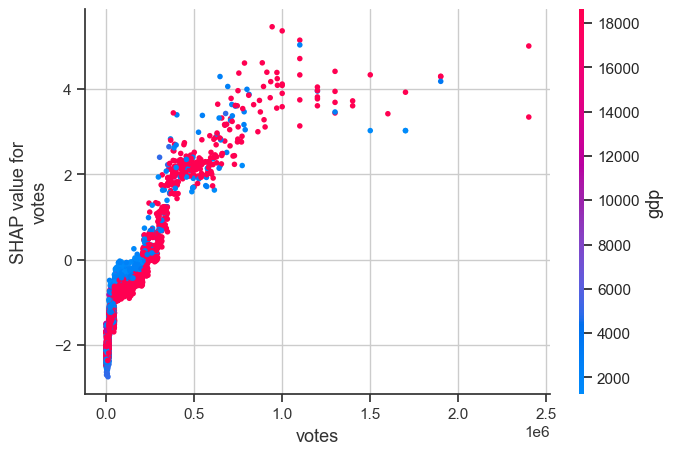

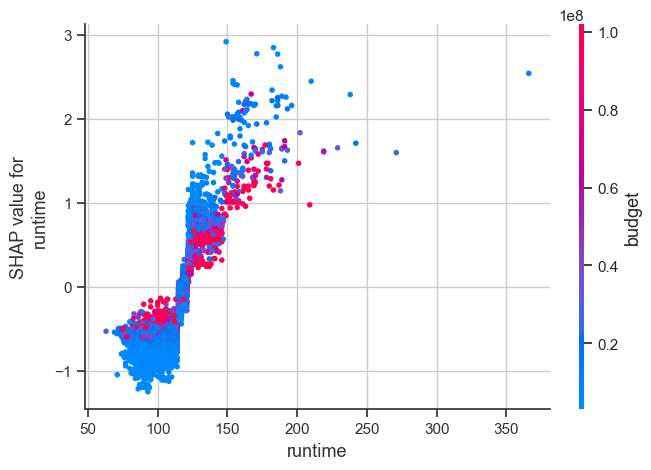

In [77]:
class_index = 2 # 0 for hit

# Now select the SHAP values for that class
shap_values_for_class = shap_values[..., class_index]

# Generate dependence plots for some selected features for this class
selected_features = ['votes', 'runtime']
for feature_name in selected_features:
    # Find the index of the feature in the feature names
    feature_index = X_train.columns.get_loc(feature_name)
    
    # Plot the dependence plot for the selected class
    # Make sure to pass the correct SHAP values for the class
    shap.dependence_plot(feature_index, shap_values_for_class.values, X_train)

Votes Feature:

In the "flop" class, votes had a strong negative influence on the likelihood of a flop as the number of votes increased. In the "hit" class, the effect of votes is positive and more pronounced, indicating a strong influence of votes on the likelihood of a movie being a hit.
Runtime Feature:

In the "flop" class, longer runtime tends to push the prediction away from being a flop, suggesting that movies with longer runtimes are less likely to flop. In the "hit" class, runtime also influences the prediction positively but not as strongly, suggesting it's less of a defining feature for a movie to be a hit.
Interactions with Budget and GDP:

In the "flop" class, the budget seems to have a slight interaction effect with runtime, where higher-budget movies with shorter runtime could still flop. In the "hit" class, the interaction is less clear, suggesting that the budget may not play as significant a role in the prediction of a hit.

These insights are valuable as they show how the model interprets features differently when predicting different outcomes (flop vs. hit), highlighting the non-linear and interaction effects that XGBoost captures beyond what a linear model would show.

## Clustering of Shapley Values

Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\phili\anaconda3\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "C:\Users\phili\anaconda3\lib\threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\phili\anaconda3\lib\subprocess.py", line 1495, in _readerthread
    buffer.append(fh.read())
  File "C:\Users\phili\anaconda3\lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 30: character maps to <undefined>
  File "C:\Users\phili\anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 202, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()


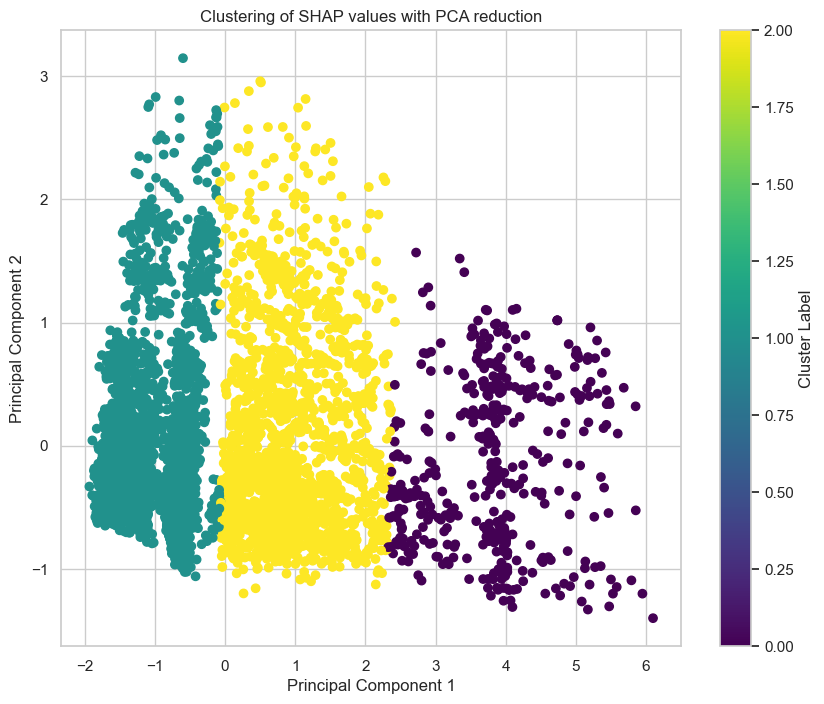

In [79]:
# Assuming shap_values have been calculated and shap_values.values contains the matrix of SHAP values
shap_values_matrix = shap_values.values

# Perform PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
shap_values_pca = pca.fit_transform(shap_values_matrix.reshape(shap_values_matrix.shape[0], -1))

# Use KMeans clustering, you can adjust the number of clusters 'n_clusters' as needed
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(shap_values_pca)

# Visualize the results of PCA reduction with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(shap_values_pca[:, 0], shap_values_pca[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('Clustering of SHAP values with PCA reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

Cluster 0 (Purple - Flops):

This cluster could represent movies that are more likely to be categorized as flops by your model. The SHAP values for this group might show negative impacts from features that are typically associated with less successful movies. For example, these could be lower votes, less runtime, or smaller budgets. If these points cluster around lower SHAP values for important features like votes, it indicates that such features contribute to decreasing the predicted success.


Cluster 1 (Green - Neither):

Movies in this cluster are neither clear hits nor clear flops according to the model. These might be average-performing movies. The characteristics of this cluster might not be as strong or as defining as the other two, showing moderate levels of the features contributing to a movie's success or failure. The features for this group likely don't push the model's prediction strongly in either direction but rather indicate a moderate impact.


Cluster 2 (Yellow - Hits):

This cluster is likely representative of movies that the model predicts as hits. The SHAP values for these movies might show positive impacts from features such as high votes, larger budgets, or optimal runtimes that are associated with successful movies. The clustering here could indicate high SHAP values for these features, suggesting that they have a significant positive effect on the model's prediction of success.